# TP 1 : Image Classification and Regression


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as k
import keras
from keras.models import Sequential, Model
from keras.layers import Input,Conv2D,Convolution2D,MaxPooling2D,Dense,UpSampling2D, Activation, Flatten,BatchNormalization,Dropout, Cropping2D, concatenate, ZeroPadding2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.optimizers import SGD, Adam
from sklearn.preprocessing import StandardScaler
from keras.callbacks import TensorBoard
classes_text = ["rectangle", "disk", "triangle"]

# 1. Getting Started


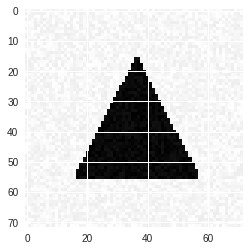

In [6]:
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

## 2. Simple Classification
We can generate a training set of images of simple geometric shapes (rectangle, disk, triangle) centered in the images

In [32]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
Y_train_cat = keras.utils.to_categorical(Y_train, 3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


We build and train a linear classifier in Keras to classify a image into one of the three possiblecategories (i.e. rectangle, disk, triangle).

In [0]:
def linear_classifier():
    model = keras.Sequential()
    model.add(Dense(3, input_dim=X_train.shape[1], activation='softmax'))
    return model

### SGD Optimizer

In [39]:
model_sgd = linear_classifier()
optim_sgd = SGD(lr = 0.001, decay = 1e-6, momentum=0.9)
model_sgd.compile(loss='categorical_crossentropy', optimizer=optim_sgd, metrics=['accuracy'])
results = model_sgd.fit(X_train, Y_train_cat, epochs = 30)

Epoch 1/30
300/300 [==============================] - 0s 1ms/step - loss: 1.1944 - acc: 0.3700
Epoch 2/30
300/300 [==============================] - 0s 110us/step - loss: 0.8659 - acc: 0.5533
Epoch 3/30
300/300 [==============================] - 0s 106us/step - loss: 0.6830 - acc: 0.6467
Epoch 4/30
300/300 [==============================] - 0s 116us/step - loss: 0.4312 - acc: 0.8533
Epoch 5/30
300/300 [==============================] - 0s 97us/step - loss: 0.3295 - acc: 0.9267
Epoch 6/30
300/300 [==============================] - 0s 95us/step - loss: 0.3877 - acc: 0.8367
Epoch 7/30
300/300 [==============================] - 0s 118us/step - loss: 0.2834 - acc: 0.9167
Epoch 8/30
300/300 [==============================] - 0s 102us/step - loss: 0.2612 - acc: 0.8967
Epoch 9/30
300/300 [==============================] - 0s 96us/step - loss: 0.2315 - acc: 0.9200
Epoch 10/30
300/300 [==============================] - 0s 121us/step - loss: 0.3174 - acc: 0.8400
Epoch 11/30
300/300 [=============

### Plot the model accuracy

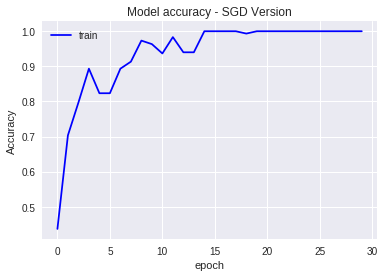

In [47]:
# history for Accuracy
plt.plot(results.history['acc'], color='blue')
plt.title('Model accuracy - SGD Version')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='best')
plt.show()

### Adam Optimizer

In [43]:
model_adam = linear_classifier()
optim_adam = Adam()
model_adam.compile(loss='categorical_crossentropy', optimizer=optim_adam, metrics=['accuracy'])
results = model_adam.fit(X_train, Y_train_cat, epochs = 30)

Epoch 1/30
300/300 [==============================] - 0s 2ms/step - loss: 1.8676 - acc: 0.4367
Epoch 2/30
300/300 [==============================] - 0s 120us/step - loss: 0.7582 - acc: 0.7033
Epoch 3/30
300/300 [==============================] - 0s 126us/step - loss: 0.4858 - acc: 0.7967
Epoch 4/30
300/300 [==============================] - 0s 107us/step - loss: 0.3742 - acc: 0.8933
Epoch 5/30
300/300 [==============================] - 0s 120us/step - loss: 0.3553 - acc: 0.8233
Epoch 6/30
300/300 [==============================] - 0s 118us/step - loss: 0.3459 - acc: 0.8233
Epoch 7/30
300/300 [==============================] - 0s 108us/step - loss: 0.2983 - acc: 0.8933
Epoch 8/30
300/300 [==============================] - 0s 127us/step - loss: 0.2668 - acc: 0.9133
Epoch 9/30
300/300 [==============================] - 0s 111us/step - loss: 0.2086 - acc: 0.9733
Epoch 10/30
300/300 [==============================] - 0s 115us/step - loss: 0.1981 - acc: 0.9633
Epoch 11/30
300/300 [==========

### Plot the model accuracy

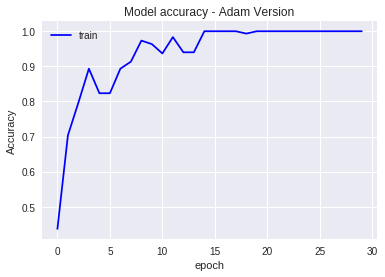

In [45]:
# history for Accuracy
plt.plot(results.history['acc'], color='blue')
plt.title('Model accuracy - Adam Version')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='best')
plt.show()


### Testing the two optimizers
We will test the two models on a sample

In [58]:
[X_test, Y_test] = generate_dataset_classification(300, 20)
Y_test_cat = keras.utils.to_categorical(Y_test, 3)


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


*** Model accuracy on a sample***

In [49]:
score_sgd, acc_sgd = model_sgd.evaluate(X_test, Y_test_cat,batch_size=32)
print('Test accuracy with SGD:', acc_sgd)

score_adam, acc_adam = model_adam.evaluate(X_test, Y_test_cat,batch_size=32)
print('Test accuracy with Adam:', acc_adam)

300/300 [==============================] - 0s 680us/step
Test accuracy with SGD: 0.9866666666666667
300/300 [==============================] - 0s 676us/step
Test accuracy with Adam: 0.9933333333333333


***Conclusion***
*   Both optimizers manage to give good predictions and converge correctly.
*   Adam optimizer does slightly better than SGD optimizer 
*   The SGD can be improved by the momentum and the nesterov version.


## 3. Vizualization of the solution
we consider the model with Adam optimizer in this section.
We visualize the weights of the linear classifier.

In [0]:
weights = model_adam.get_weights()[0].reshape(IMAGE_SIZE,IMAGE_SIZE,3)

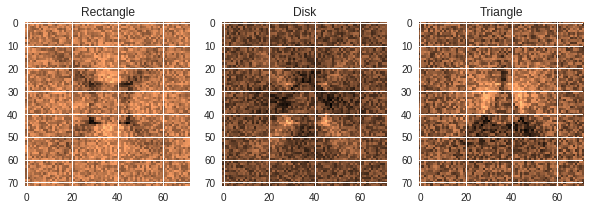

In [55]:
plt.subplots(1, 3, figsize = (10,10))
plt.subplot(131)
plt.imshow(weights[:,:,0], cmap='copper')
plt.title('Rectangle')

plt.subplot(132)
plt.imshow(weights[:,:,1], cmap='copper')
plt.title('Disk')

plt.subplot(133)
plt.imshow(weights[:,:,2], cmap='copper')
plt.title('Triangle')

plt.show()

* One can see that each column contains the weights learned to predict the corresponding category. 
* We can see the shape of the rectangle, the disk and the triangle in the displayed weights graphs.
## 4. A More Difficult Classification Problem


In [59]:
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)
Y_train_cat = keras.utils.to_categorical(Y_train, 3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


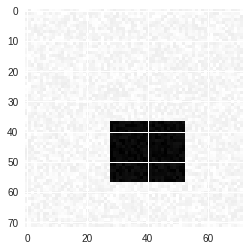

In [65]:
idx = 36
plt.imshow(X_train[idx].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

### Linear Classifier
We will train the same network  to see if it can handle with this more difficult classification problem.

In [66]:
model_linear = linear_classifier()
optim_adam = Adam()
model_linear.compile(loss='categorical_crossentropy', optimizer=optim_adam, metrics=['accuracy'])
model_linear.fit(X_train, Y_train_cat, epochs = 30)

Epoch 1/30
1000/1000 [==============================] - 1s 594us/step - loss: 1.5214 - acc: 0.3720
Epoch 2/30
1000/1000 [==============================] - 0s 107us/step - loss: 0.9756 - acc: 0.4860
Epoch 3/30
1000/1000 [==============================] - 0s 109us/step - loss: 0.8985 - acc: 0.5350
Epoch 4/30
1000/1000 [==============================] - 0s 104us/step - loss: 1.1072 - acc: 0.5460
Epoch 5/30
1000/1000 [==============================] - 0s 110us/step - loss: 1.0684 - acc: 0.5750
Epoch 6/30
1000/1000 [==============================] - 0s 115us/step - loss: 0.7948 - acc: 0.6130
Epoch 7/30
1000/1000 [==============================] - 0s 116us/step - loss: 0.8404 - acc: 0.5990
Epoch 8/30
1000/1000 [==============================] - 0s 108us/step - loss: 0.8125 - acc: 0.6050
Epoch 9/30
1000/1000 [==============================] - 0s 111us/step - loss: 0.8752 - acc: 0.5630
Epoch 10/30
1000/1000 [==============================] - 0s 110us/step - loss: 0.8304 - acc: 0.6110
Epoch 11/

In [67]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


*** Model accuracy on testing set***

In [68]:
model_linear.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 689us/step


[0.8236109137535095, 0.5966666666666667]

*** Conclusion ***
* It is notable that the linear model is insufficient for this classfication task.
* We also notice that the model executed here tends to overfit.
* Our previous model scores poorly on the test set with an accuracy of 57%.

> We should  use a more sophisticated architecture (deeper NN) to solve this problem.




### Convolutional Neural Network
We will use a Convolutional Neural Network. We will begin by using a one convolutional layer with 16 5×5 filters, 1 pooling layer, and one fully connected layer.

###Simple CNN

In [0]:
def simple_CNN():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size = (5,5), input_shape = (IMAGE_SIZE,IMAGE_SIZE,1), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    return model

We reshape the data to 2D arrays (images)

In [0]:
n_train =  X_train.shape[0]
X_train = X_train.reshape(n_train,IMAGE_SIZE,IMAGE_SIZE,1)

In [71]:
model_cnn = simple_CNN()
optim_adam = Adam()
model_cnn.compile(loss='categorical_crossentropy', optimizer=optim_adam, metrics=['accuracy'])
model_cnn.fit(X_train, Y_train_cat, epochs = 30, batch_size=32)

Epoch 1/30
1000/1000 [==============================] - 4s 4ms/step - loss: 1.0285 - acc: 0.5120
Epoch 2/30
1000/1000 [==============================] - 4s 4ms/step - loss: 0.7721 - acc: 0.7030
Epoch 3/30
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6647 - acc: 0.7340
Epoch 4/30
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6376 - acc: 0.7320
Epoch 5/30
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5996 - acc: 0.7740
Epoch 6/30
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5381 - acc: 0.7850
Epoch 7/30
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5115 - acc: 0.8120
Epoch 8/30
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4684 - acc: 0.8140
Epoch 9/30
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4468 - acc: 0.8330
Epoch 10/30
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4060 - acc: 0.8520
Epoch 11/30
1000/1000 [======

In [0]:
n_test = X_test.shape[0]
X_test = X_test.reshape(n_test,IMAGE_SIZE,IMAGE_SIZE,1)

*** Model accuracy on testing set***

In [73]:
model_cnn.evaluate(X_test, Y_test)

300/300 [==============================] - 1s 3ms/step


[0.46270286083221435, 0.823333334128062]

***Conclusion***
* Comparing to the linear classifier, this simple CNN architecture has better performance. 
* We can boost the performance by using deeper architectures

***Deeper CNN***

In [0]:
def deeper_CNN():
    model_deepercnn = Sequential()
    model_deepercnn.add(Conv2D(filters=32, kernel_size=(5,5), input_shape=(IMAGE_SIZE,IMAGE_SIZE,1), activation='relu'))
    model_deepercnn.add(MaxPooling2D((5,5)))
    model_deepercnn.add(Dropout(0.5))
    model_deepercnn.add(Flatten())
    model_deepercnn.add(Dense(128, activation='relu'))
    model_deepercnn.add(Dense(3, activation='softmax'))
    model_deepercnn.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])        
    return model_deepercnn

In [76]:
model_deepercnn = deeper_CNN()
model_deepercnn.fit(X_train, Y_train_cat, epochs = 30, batch_size=16)

Epoch 1/30
1000/1000 [==============================] - 6s 6ms/step - loss: 0.8975 - acc: 0.5850
Epoch 2/30
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6057 - acc: 0.7720
Epoch 3/30
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4451 - acc: 0.8460
Epoch 4/30
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3826 - acc: 0.8680
Epoch 5/30
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2683 - acc: 0.9080
Epoch 6/30
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2199 - acc: 0.9260
Epoch 7/30
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1804 - acc: 0.9450
Epoch 8/30
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1770 - acc: 0.9450
Epoch 9/30
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1296 - acc: 0.9620
Epoch 10/30
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1247 - acc: 0.9640
Epoch 11/30
1000/1000 [======

*** Model accuracy on testing set***

In [77]:
model_deepercnn.evaluate(X_test, Y_test)

300/300 [==============================] - 1s 3ms/step


[0.34755905230840045, 0.9099999992052714]

**Conclusion***
* With this deeper network, we can enhance the performance of our model.

## 5. A Regression Problem
The challenge is to predict the image locations of the vertices of a triangle, given an image of this
triangle.
### Generation 

In [78]:
[X_train, Y_train] = generate_dataset_regression(3000, 20)
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

***Normalization and sorting :***
* We should  normalize Y_train and Y_test before training and testing.
* We should also sort Y_train and Y_test with respect to one of their coordinates.

In [0]:
normalizer = StandardScaler()
Y_train_norm = normalizer.fit_transform(Y_train)
Y_test_norm = normalizer.fit_transform(Y_test)

In [0]:
def sort_coord(v):
    Y_temp = np.array(v)
    Y_temp = Y_temp.reshape((3, 2))
    Y_temp = Y_temp[Y_temp[:,-1].argsort()].flatten()
    return Y_temp

In [0]:
Y_train_1 = np.array([sort_coord(vertices) for vertices in Y_train_norm])
Y_test_1 = np.array([sort_coord(vertices) for vertices in Y_test_norm])

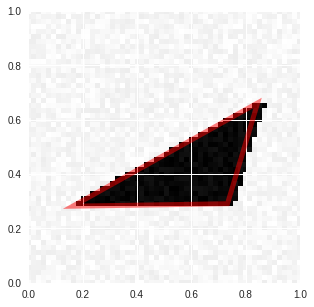

In [83]:
idx = 38
visualize_prediction(X_train[idx], Y_train[idx])

### CNN for regression

In [0]:
n_train = X_train.shape[0]
X_train = X_train.reshape(n_train,IMAGE_SIZE,IMAGE_SIZE,1)
n_test = X_test.shape[0]
X_test = X_test.reshape(n_test,IMAGE_SIZE,IMAGE_SIZE,1)

In [0]:
def regression_CNN():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(72, 72, 1), padding='same'))
    model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))
    model.add(Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))
    model.add(Conv2D(128, (3, 3), activation="relu", padding='same'))
    model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))
    model.add(Conv2D(256, (3, 3), activation="relu", padding='same'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6))

    model.compile(optimizer='adam', loss='mae')
    return model
    

In [87]:
model_reg = regression_CNN()
model_reg.fit(X_train, Y_train_1, validation_data=(X_test, Y_test_1), epochs = 30, batch_size=64)

Train on 3000 samples, validate on 300 samples
Epoch 1/30
3000/3000 [==============================] - 22s 7ms/step - loss: 0.7179 - val_loss: 0.5985
Epoch 2/30
3000/3000 [==============================] - 20s 7ms/step - loss: 0.5336 - val_loss: 0.4298
Epoch 3/30
3000/3000 [==============================] - 20s 7ms/step - loss: 0.4345 - val_loss: 0.3716
Epoch 4/30
3000/3000 [==============================] - 20s 7ms/step - loss: 0.4020 - val_loss: 0.3491
Epoch 5/30
3000/3000 [==============================] - 20s 7ms/step - loss: 0.3843 - val_loss: 0.3259
Epoch 6/30
3000/3000 [==============================] - 20s 7ms/step - loss: 0.3713 - val_loss: 0.3223
Epoch 7/30
3000/3000 [==============================] - 20s 7ms/step - loss: 0.3598 - val_loss: 0.3177
Epoch 8/30
3000/3000 [==============================] - 20s 7ms/step - loss: 0.3298 - val_loss: 0.2722
Epoch 9/30
3000/3000 [==============================] - 20s 7ms/step - loss: 0.3013 - val_loss: 0.2526
Epoch 10/30
3000/3000 [===

In [0]:
predictions_test = model_reg.predict(X_test)
Y_pred = normalizer.inverse_transform(predictions_test)

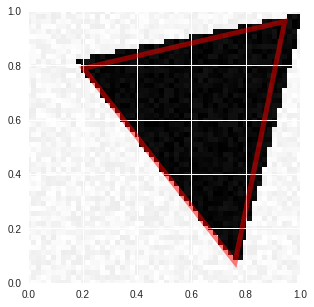

In [97]:
idx = 38
visualize_prediction(X_test[idx], Y_pred[idx])

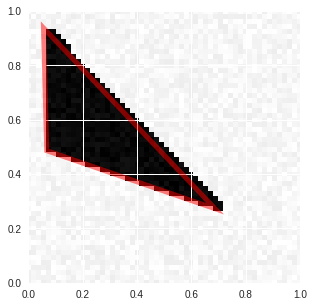

In [101]:
idx = 79
visualize_prediction(X_test[idx], Y_test[idx])

## 6. Image Denoising
In this section, we implement a hourglass network for denoising.
 
###Modify functions


In [0]:
def generate_a_rectangle2(free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    noise = 10 + 20*np.random.random()
    
    return (generate_a_drawing(figsize, U, V, 0), 
            (generate_a_drawing(figsize, U, V, noise)+ noise) / (255 + 2 * noise))


def generate_a_disk2(free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    noise = 10 + 20*np.random.random()
    return (generate_a_drawing(figsize, U, V, 0), 
            (generate_a_drawing(figsize, U, V, noise)+ noise) / (255 + 2 * noise))



def generate_a_triangle2(free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    noise = 10 + 20*np.random.random()

    imdata = (generate_a_drawing(figsize, U, V, 0), 
              (generate_a_drawing(figsize, U, V, noise)+ noise) / (255 + 2 * noise))
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


def generate_dataset_denoising(nb_samples, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X_train = np.zeros([nb_samples,im_size])
    X_test = np.zeros([nb_samples,im_size])
    print('Creating data')
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X_test[i], X_train[i] = generate_a_rectangle2(free_location)
        elif category == 1: 
            X_test[i], X_train[i] = generate_a_disk2(free_location)
        else:
            [(X_test[i], X_train[i]), V] = generate_a_triangle2(free_location)
    return [X_train, X_test]

###Data preprocessing###


In [120]:
[X_train, Y_train] = generate_dataset_denoising(1500, free_location=True)
X_train = X_train.reshape((1500,72,72,1))/255
Y_train = Y_train.reshape((1500,72,72,1))/255
[X_val, Y_val] = generate_dataset_denoising(300, free_location=True)
X_val = X_val.reshape((300,72,72,1))/255
Y_val = Y_val.reshape((300,72,72,1))/255

Creating data
Creating data


###Create Model

In [0]:
def auto_encoder():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(72, 72, 1), padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(1, (3, 3), activation="sigmoid", padding='same'))
    
    return model 

In [0]:
model = auto_encoder()
model.compile(optimizer='adam', loss='binary_crossentropy')

***Fit Model***


In [125]:
model.fit(X_train, Y_train, epochs=10, batch_size=16,validation_data=(X_val, Y_val),  callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 1500 samples, validate on 300 samples
Epoch 1/10
1500/1500 [==============================] - 65s 43ms/step - loss: 0.3497 - val_loss: 0.2866
Epoch 2/10
1500/1500 [==============================] - 66s 44ms/step - loss: 0.1452 - val_loss: 0.0634
Epoch 3/10
1500/1500 [==============================] - 64s 43ms/step - loss: 0.0327 - val_loss: 0.0249
Epoch 4/10
1500/1500 [==============================] - 65s 43ms/step - loss: 0.0247 - val_loss: 0.0205
Epoch 5/10
1500/1500 [==============================] - 65s 43ms/step - loss: 0.0201 - val_loss: 0.0239
Epoch 6/10
1500/1500 [==============================] - 65s 43ms/step - loss: 0.0193 - val_loss: 0.0221
Epoch 7/10
1500/1500 [==============================] - 66s 44ms/step - loss: 0.1528 - val_loss: 1.4774
Epoch 8/10
1500/1500 [==============================] - 65s 43ms/step - loss: 1.4032 - val_loss: 1.4774
Epoch 9/10
1500/1500 [==============================] - 65s 43ms/step - loss: 1.4032 - val_loss: 1.4774
Epoch 10/10
1500/

*** Prediction and visualization***

In [0]:
Y_pred = model.predict(X_val)

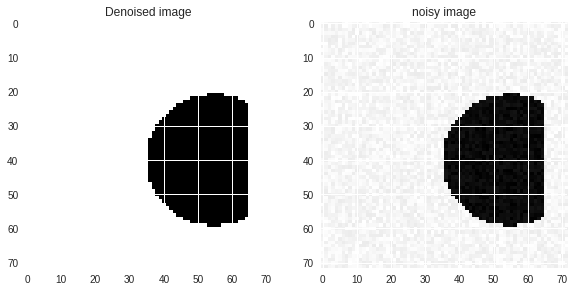

In [136]:
idx = 38

plt.subplots(1, 2, figsize = (15,15))
plt.subplot(131)
plt.imshow(Y_val[idx,:,:,0], cmap='gray')
plt.title('Denoised image')

plt.subplot(132)
plt.imshow(X_val[idx,:,:,0], cmap='gray')
plt.title('noisy image')


plt.show()

###Conclusion###
* the hourglass network for denoising  consists of a convolutional autoencoder. 
* The goal achieved is to train the autoencoder to map noisy digits images to clean digits images.
* We can see that the picture without noise it's much better than the noizy one.